# Text recognition task 3
-----------------------------------------
*José Carlos Aradillas jcaradillas@gmail.com*
    
-----------------------------------------
In this notebook, I document all the steps followed to complete the task for the Senior ML Research Engineer Test Task at Veriff.

I will split the statement of the problem and the several steps asked by Veriff in the following format:
>### Title of something asked by Veriff
> Statement and description of the problem

I document every step with comments and references preceding the different cells of code. I write also some inline code comments `# comment in the code` to clarify their porpuse.

Let's continue with Part 3:

>## 3. Attach an STN to your text recognition model
>
>As the next step, you will attach a visual attention mechanism called Spatial Transformer Networks (STN for short) to your existing architecture. You can read more about the spatial transformer networks in [this DeepMind paper](https://arxiv.org/abs/1506.02025). STNs allow a neural network to perform spatial manipulation on the input data within the network to enhance the geometric invariance of the model. It can be a useful mechanism because CNNs are not invariant to rotation and scale and more general affine transformations. STNs can be simply inserted into existing convolutional architectures without any extra training supervision or modification to the optimization process. [This PyTorch tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html) might help you kick off this step. Please investigate if attaching an STN module to your text recognition model can help to improve the performance of the baseline. Compare the performance of the new model in your preferred evaluation metric.

First of all, let's import all the neccesary libraries that will be use in the code to solve the task.

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from torchvision import datasets, models
from torchvision import transforms as T
import random
from tqdm import tqdm
import os
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import VisionDataset
from typing import Any, Callable, List, Optional, Tuple
import time

/opt/anaconda3/envs/ve-htr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Once the libraries have been imported, let's initialize the random seeds of every library I will use to randomize things, with the aim of achieving reproducibility. 

Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms and furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds [Reproducibility in Pytorch](https://pytorch.org/docs/stable/notes/randomness.html).

However, let's limit the number of sources of nondeterministic behavior for a specific platform, device, and PyTorch release:

In [2]:
random.seed(60)
np.random.seed(60)
_=torch.manual_seed(60)

First, let's import some modules we built in the previous sections of the task. We will import the `SEMNIS` dataset with its `collate` method implemented in part 1 of the task. 

We will also import the htrModels we used in part 2.

In [3]:
from datasets.semnist import SEMNIST, collate_semnist, collate_semnist_fixed_length
from models import htrModels
from utils.tools import eval_performance, Train_Eval

When performing batch training, Pytorch needs that all the input images to be tensors of the same shape (height and width). The next custom `collate_semnist` method is created to pad the smaller images in each batch to have the width of the widest image in the batch. It also pad the targets to have the same length.

The `collate_semnist` function will be an argument of the `Dataloader` which will load our batched data.

Now we have our dataset preparated and all the methods to load the dataset to feed our models, following the **Pytorch** Dataset framework. The steps for load the dataset are the following.
1. Instantiate the EMNIST trainset, with the command `trainset = SEMNIST('~/.pytorch/SEMNIST_data/', dataset = 'train', transform = transform)`. We apply `ToTensor()` and `Normalize` transformations in the images to get directly the inputs of our models.

2. Instantiate the EMNIST testset, aplying the same command sentence that for the training case but the argument in the call is `dataset='test'`.

3. Instantiate both dataloaders in shuffle mode to randomize the batches, we choose the batchsize and set the `collate_fn` argument with our custom `collate_semnist` explained above.

In [4]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
transform = T.Compose([T.ToTensor(),
                              T.Normalize((0.5,), (0.5,)),
                              ])
trainset = SEMNIST('~/.pytorch/SEMNIST_data/', dataset = 'train', transform = transform)
testset = SEMNIST('~/.pytorch/SEMNIST_data/', dataset = 'test', transform = transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=collate_semnist)
testloader = DataLoader(testset, batch_size=64, shuffle=True, collate_fn=collate_semnist)

In the following code we show some imformation about the **SEMNIST** dataset we have just loaded. We check that the train set has 100,000 samples and the testset has 16,000 samples. We also show some samples of pairs image, target in the training set.

The train set has 100000 samples.
The test set has 16000 samples.


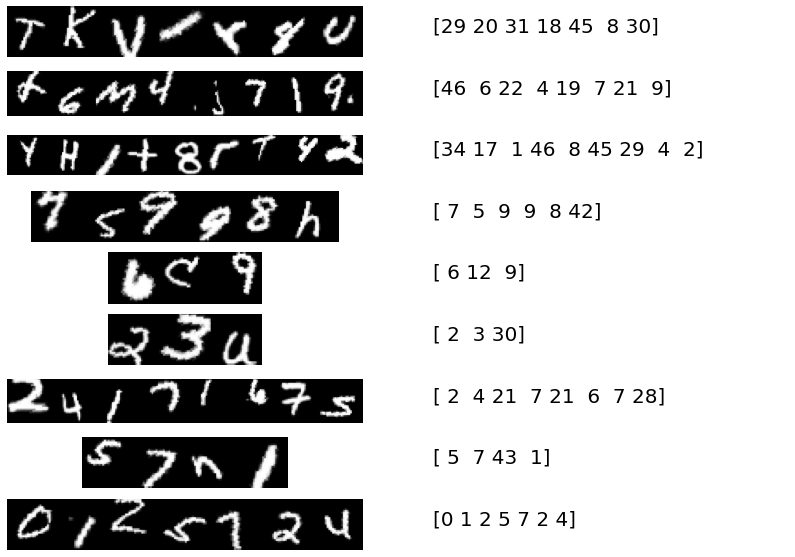

In [5]:
print('The train set has {} samples.'.format(len(trainset)))
print('The test set has {} samples.'.format(len(testset)))
num_plotted_samples = 9
fig, axs = plt.subplots(num_plotted_samples, 2,figsize=(14, 10))
for ind in range(num_plotted_samples): 
    img, label = trainset[ind]
    axs[ind,0].imshow(img.squeeze().numpy(), cmap='Greys_r')
    axs[ind,1].text(0,.5,str(label.numpy()), fontsize=20)
    axs[ind,0].axis('off')
    axs[ind,1].axis('off')

Until now, our models admited different lengths sequences (the goal was to reduce computation cost when doing the forward and backward pass with images smaller than maximun length (in our case 10 labels)). If we want to apply Spatial Transformer Networks, where the localisation network output $\theta$ dependes on the fixed size of the input images. In this case, our model input shoud have the same size. In our case, 28x280 pixels.

In [9]:
stn_model = htrModels.STN_CNN(height=28, nlabels=47,prob=0)

In [ ]:
demoset = SEMNIST('~/.pytorch/SEMNIST_data/', dataset = 'test', transform = transform)
demoloader = DataLoader(demoset, batch_size=64, shuffle=True, collate_fn=collate_semnist_fixed_length)

In [ ]:
model_with_train = Train_Eval(stn_model,epochs=30)
model_with_train.trainloop(trainloader, testloader)

For sequences, could be a good idea to implement [Long Short-Term Memory Spatial Transformer Network](https://arxiv.org/pdf/1901.02273.pdf).

In [ ]:
eval_performance(stn_model, demoloader)

In [ ]:
eval_performance(stn_model, testloader)

In [8]:
stn_model

NameError: name 'stn_model' is not defined

In [ ]:
plt.plot(model_with_train.loss_during_training)
plt.plot(model_with_train.valid_loss_during_training)

In [ ]:
with torch.no_grad():
    img, label, width, length = next(iter(demoloader))
    probs = stn_model.forward(img)
    top_p, top_class = probs.topk(1, dim=1)
    top_class[0]
    procesed_img = stn_model.stn(img)
    f, axarr = plt.subplots(2, 1)
    axarr[0].imshow(img[2].squeeze().numpy(), cmap='Greys_r')
    axarr[0].set_title('Dataset Images')

    axarr[1].imshow(procesed_img[2][1].squeeze().numpy(), cmap='Greys_r')
    axarr[1].set_title('Transformed Images')


In [ ]:
a = [None]*10
a[1] = 2
a

In [ ]:
14080/64

In [11]:
from models.htrModels import CNN
base_model = CNN(height=28, nlabels=47,prob=0)

In [12]:
model_with_train = Train_Eval(base_model,epochs=30)
model_with_train.trainloop(trainloader, testloader)

100%|█████████████████████████████████████████| 250/250 [00:26<00:00,  9.58it/s]


Epoch 0. Training loss: 0.557284540689228, Validation loss: 0.3846642227172852. Time per epoch: 323.78372502326965 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.25it/s]


Epoch 0. Training CER: 0.19027741253376007, Validation CER: 0.19503916800022125.


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 19.23it/s]


Epoch 1. Training loss: 0.3500150945883719, Validation loss: 0.33071163922548297. Time per epoch: 194.27347207069397 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.30it/s]


Epoch 2. Training loss: 0.31653908205886566, Validation loss: 0.31947130554914477. Time per epoch: 194.80083298683167 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.30it/s]


Epoch 3. Training loss: 0.299594674900565, Validation loss: 0.3066188931465149. Time per epoch: 196.4866440296173 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.65it/s]


Epoch 4. Training loss: 0.28860987210914407, Validation loss: 0.3019528270959854. Time per epoch: 199.3056719303131 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 19.21it/s]


Epoch 5. Training loss: 0.2805365282644161, Validation loss: 0.2941019991636276. Time per epoch: 196.9229507446289 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.29it/s]


Epoch 6. Training loss: 0.274321999141061, Validation loss: 0.291532119512558. Time per epoch: 196.33668494224548 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 19.17it/s]


Epoch 7. Training loss: 0.2694337955954284, Validation loss: 0.28643889433145525. Time per epoch: 315.58932089805603 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.35it/s]


Epoch 8. Training loss: 0.26500251448772233, Validation loss: 0.28269078916311263. Time per epoch: 195.53034687042236 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.25it/s]


Epoch 9. Training loss: 0.2619646036293136, Validation loss: 0.28375804966688156. Time per epoch: 196.62274813652039 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 19.15it/s]


Epoch 10. Training loss: 0.25846456632885656, Validation loss: 0.28481563943624494. Time per epoch: 195.8790111541748 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.27it/s]


Epoch 10. Training CER: 0.13945834338665009, Validation CER: 0.1524970978498459.


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.34it/s]


Epoch 11. Training loss: 0.2563478021440945, Validation loss: 0.27953387862443924. Time per epoch: 195.61778712272644 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.29it/s]


Epoch 12. Training loss: 0.2539562374372476, Validation loss: 0.28089530688524245. Time per epoch: 195.6859209537506 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.38it/s]


Epoch 13. Training loss: 0.25198306167118073, Validation loss: 0.2785031906366348. Time per epoch: 196.9687201976776 seconds


100%|███████████████████████████████████████| 250/250 [1:00:02<00:00, 14.41s/it]


Epoch 14. Training loss: 0.24988519661104686, Validation loss: 0.27657345360517505. Time per epoch: 4241.4110560417175 seconds


100%|█████████████████████████████████████████| 250/250 [00:30<00:00,  8.26it/s]


Epoch 15. Training loss: 0.24820943309264693, Validation loss: 0.27350524497032164. Time per epoch: 2977.8187210559845 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.31it/s]


Epoch 16. Training loss: 0.2467973507506986, Validation loss: 0.27556873100996016. Time per epoch: 275.21994185447693 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.40it/s]


Epoch 17. Training loss: 0.24528723921786497, Validation loss: 0.2760007103085518. Time per epoch: 196.9058108329773 seconds


 41%|████████████████▍                       | 640/1563 [01:18<01:53,  8.14it/s]


KeyboardInterrupt: 

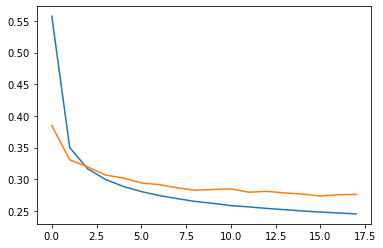

In [13]:
plt.plot(model_with_train.loss_during_training)
plt.plot(model_with_train.valid_loss_during_training)

In [10]:
sum(p.numel() for p in stn_model.parameters() if p.requires_grad)

47369

In [6]:
sum(p.numel() for p in cnn_6_model.parameters() if p.requires_grad)

263135